# <center> BBC NEWS CLASSIFICATION

In [406]:
# import Libraries
import os #operating system interactions
#import random
import nltk #nlp library
from nltk.tokenize import word_tokenize #tokenizing corpus into words
from nltk.corpus import stopwords #removing unwanted words
from nltk.stem import WordNetLemmatizer #word lemmatizer
from sklearn.feature_extraction.text import CountVectorizer #feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer #feature extraction
from gensim.models import word2vec  # feature extraction
import re #removing unwanted characters
import pandas as pd #data manipulation
import numpy as np #data manipulation
import matplotlib.pyplot as plt
from tqdm import tqdm #progress bar for iteration
import warnings
warnings.filterwarnings("ignore")

In [452]:
#Import modeling libraries
from sklearn.pipeline import Pipeline                                     
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf # deep neural networks 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, Activation, MaxPool1D, Conv1D, LSTM, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
import pickle
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swint\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### IMPORT AND EXPLORE DATA

In [448]:
path = "./bbc"                                            # folder directory
folder = os.listdir(path)                                 # get folders in the directory
folder.remove('README.TXT')                               #keep essential folders 
files_path={}                                             # initiate dictionary for file paths
data={}                                                   # initiate dictionary for data

for category in folder:
    #get folder path for category
    file_path=os.path.join(path, category)
    
    #intitiate list of files for the file category
    files_path[category]=[]
    
    #iterate files in the folder and append the paths to files_path
    for dirname, _, filenames in os.walk(file_path):
        for filename in tqdm(filenames):
               files_path[category].append(os.path.join(dirname,filename))
                
    print(category," files: ", len(files_path[category]))
    
    data[category]=[]
    #read files in the category and append content to the data dictionary 
    #values for the category
    for file in files_path[category]:
        with open(file, 'r') as f:
            text = f.read()
        data[category].append(text)

100%|████████████████████████████████████████████████████████████████████████████████████████| 510/510 [00:00<?, ?it/s]


business  files:  510


100%|████████████████████████████████████████████████████████████████████████████████████████| 386/386 [00:00<?, ?it/s]


entertainment  files:  386


100%|████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:00<?, ?it/s]


politics  files:  417


100%|████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<?, ?it/s]


sport  files:  511


100%|████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<?, ?it/s]


tech  files:  401


In [449]:
# convert data dictionary into a list of tuples with category and text content
data_list=[(key,value) for key, values in data.items() for value in values]

#convert the list into a dataframe
df=pd.DataFrame(data_list, columns=['Category', 'Content'])

print("Data has ",df.shape[0], " rows and ",df.shape[1],"columns")
df.head()

Data has  2225  rows and  2 columns


,Category,Content
0,business,Ad sales boost Time Warner profit\n\nQuarterly...
1,business,Dollar gains on Greenspan speech\n\nThe dollar...
2,business,Yukos unit buyer faces loan claim\n\nThe owner...
3,business,High fuel prices hit BA's profits\n\nBritish A...
4,business,Pernod takeover talk lifts Domecq\n\nShares in...


### DATA PREPROCESSING

In [410]:
wpt=nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
lemmatizer=WordNetLemmatizer()


def normalize_document(doc):
    #remove special characters and white spaces and turn to lowercase
    doc=re.sub(r'[^a-zA-Z\s]', '', doc)
    doc=doc.lower()
    doc=doc.strip()
    
    #tokenize document
    tokens=wpt.tokenize(doc)
    
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    #implement lemmatization with pos tags
    tagged_words = nltk.pos_tag(filtered_tokens)
    lem_words=[]
    for word in tagged_words:
        #print(word)
        if word[1]=='JJ' or word[1]=='JJS' or word[1]=='JJR':
            lem_words.append(lemmatizer.lemmatize(word[0], pos="a"))
        elif word[1]=='VB' or word[1]=='VBP' or word[1]=='VBG' or word[1]=='VBN':
            lem_words.append(lemmatizer.lemmatize(word[0], pos="v"))
        else:
            lem_words.append(lemmatizer.lemmatize(word[0]))
            
    #re-create document from filtered tokens
    doc= ' '.join(lem_words)
    
    return doc

#normalize all documents in the dataset and save in the list
norm_list=[]
for t in df["Content"]:
    norm_corpus=normalize_document(t)
    norm_list.append(norm_corpus)


#add normalized document to the dataframe   
df['Normalized_Content']=norm_list

In [411]:
df.head() #first five documents

,Category,Content,Normalized_Content
0,business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sale boost time warner profit quarterly pro...
1,business,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit high l...
2,business,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owner embattl...
3,business,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit bas profit british airway ...
4,business,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq share uk drin...


In [412]:
df["Content"][0] #first document content before normalization

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to si

In [413]:
df["Normalized_Content"][0] #first document after normalization

'ad sale boost time warner profit quarterly profit u medium giant timewarner jumped bn three month december yearearlier firm one big investor google benefited sale highspeed internet connection higher advert sale timewarner said fourth quarter sale rose bn bn profit buoyed oneoff gain offset profit dip warner bros less user aol time warner said friday owns searchengine google internet business aol mixed fortune lose subscriber fourth quarter profit lower precede three quarter however company said aols underlying profit exceptional item rose back strong internet advertising revenue hope increase subscriber offer online service free timewarner internet customer try sign aols exist customer highspeed broadband timewarner also restate result follow probe u security exchange commission sec close conclude time warner fourth quarter profit slightly good analyst expectation film division saw profit slump helped boxoffice flop alexander catwoman sharp contrast yearearlier third final film lord 

### FEATURE EXTRACTION

In [414]:
df["Category_Factor"]=pd.factorize(df["Category"])[0]

In [415]:
X=df["Normalized_Content"]
y=df["Category_Factor"]

In [416]:
# Access the actual labels (unique categories)
labels = pd.factorize(df["Category"])[1]
print("Label names:", labels)

Label names: Index(['business', 'entertainment', 'politics', 'sport', 'tech'], dtype='object')


In [417]:
X.shape

(2225,)

In [418]:
y

0       0
1       0
2       0
3       0
4       0
       ..
2220    4
2221    4
2222    4
2223    4
2224    4
Name: Category_Factor, Length: 2225, dtype: int64

In [419]:
X

0       ad sale boost time warner profit quarterly pro...
1       dollar gain greenspan speech dollar hit high l...
2       yukos unit buyer face loan claim owner embattl...
3       high fuel price hit bas profit british airway ...
4       pernod takeover talk lift domecq share uk drin...
                              ...                        
2220    bt program beat dialler scam bt introduce two ...
2221    spam email tempt net shopper computer user acr...
2222    careful code new european directive could put ...
2223    u cyber security chief resigns man make sure u...
2224    lose online game online role play game timecon...
Name: Normalized_Content, Length: 2225, dtype: object

#### BAG OF WORDS

In [420]:
#get bag of words features in sparse format
cv = CountVectorizer(min_df=1, max_df=0.8)
cv_matrix = cv.fit_transform(X)
cv_matrix = cv_matrix.toarray()
X_BW=cv_matrix
# get all unique words in the corpus
vocabs = cv.get_feature_names_out()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocabs)

,aa,aaa,aaas,aac,aadc,aaliyah,aaliyahs,aaltra,aamir,aara,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### N-GRAMS BAG OF WORDS

In [421]:
tv=CountVectorizer(ngram_range=(3,3), min_df=3, max_df=0.8) #for 3 grams
tv_matrix= tv.fit_transform(X)
tv_matrix=tv_matrix.toarray()
X_NG=tv_matrix
pd.DataFrame(tv_matrix, columns=tv.get_feature_names_out())

,abbasi mr mubanga,ability influence people,abortion drama vera,absolute rule said,academy film award,academy motion picture,accelerate lib dem,access information held,accord blog analysis,accord figure gather,...,young asian men,young people said,young player come,young star yearold,yugansk sold littleknown,yukos claim downfall,yukos legal wrangling,yulia tymoshenko said,zealand world cup,zurich premiership match
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Term Frequency- Inverse Document Frequency

In [422]:
tv=TfidfVectorizer(min_df=1, max_df=0.8, norm='l2', use_idf=True, smooth_idf=True)
tv_matrix=tv.fit_transform(X)
tv_matrix=tv_matrix.toarray()
X_TFIDF=tv_matrix
pd.DataFrame(np.round(tv_matrix, 2), columns=tv.get_feature_names_out())

,aa,aaa,aaas,aac,aadc,aaliyah,aaliyahs,aaltra,aamir,aara,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


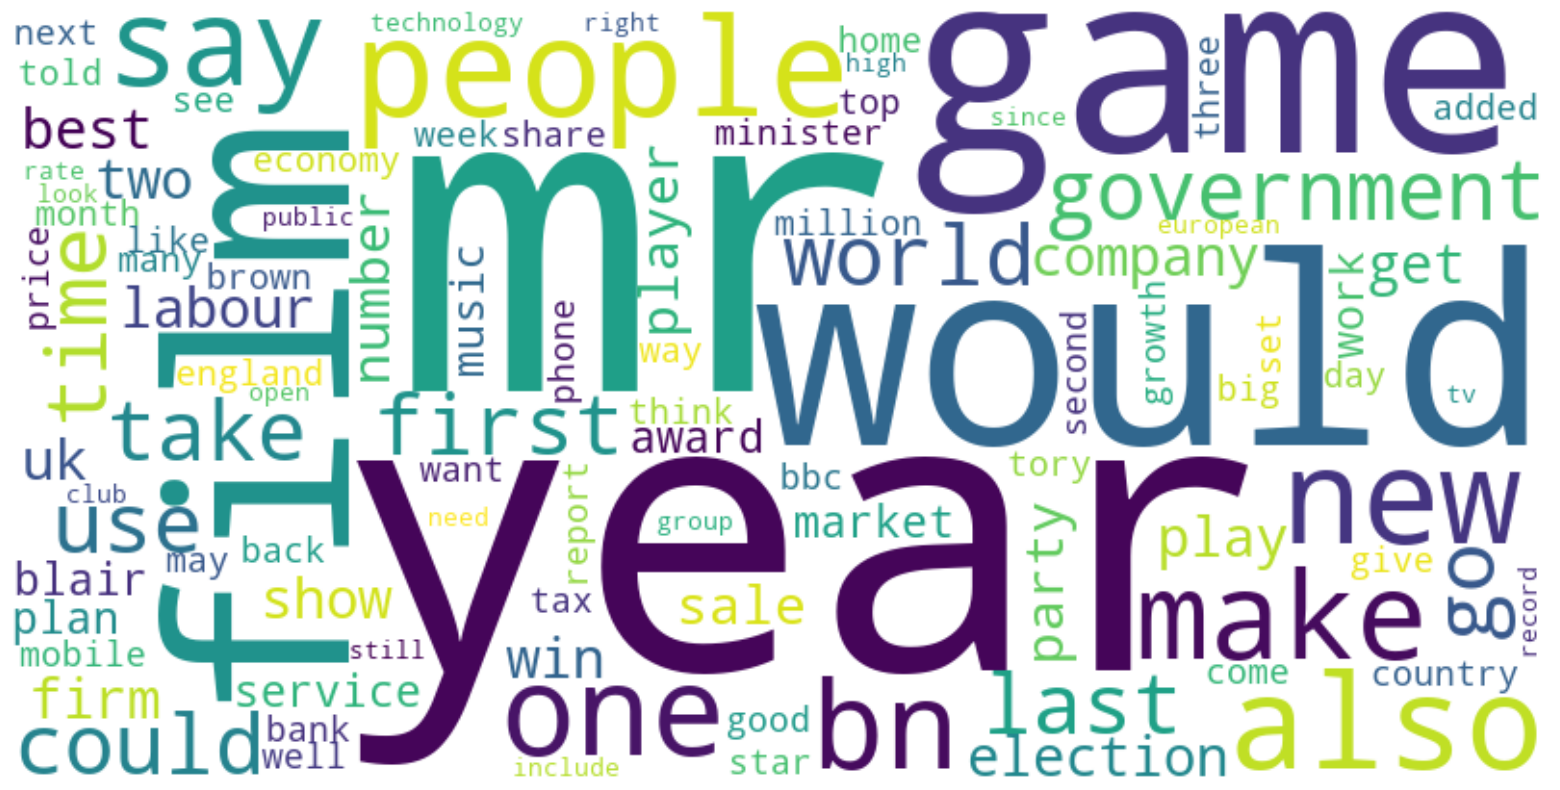

In [488]:
from wordcloud import WordCloud

# Extract the feature names (words) from the TF-IDF vectorizer
tfidf_feature_names = tv.get_feature_names_out()

# Get the average tf-idf score for each feature (word) across the entire dataset
# Multiply the tf-idf scores (stored in the 'transform' matrix) by their corresponding feature names
average_tfidf_scores = np.mean(tv_matrix, axis=0)

# dictionary with words and their average tf-idf scores
tfidf_scores = dict(zip(tfidf_feature_names, average_tfidf_scores))

# Sort the dictionary by tf-idf score in descending order
sorted_tfidf_scores = {k: v for k, v in sorted(tfidf_scores.items(), key=lambda item: item[1], reverse=True)}

# Select the top N important words (top 100)
top_n_words = dict(list(sorted_tfidf_scores.items())[:100])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_n_words)

# Plot the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axes for a cleaner look
plt.show()

In [453]:
# Save the TF-IDF vectorizer (tv is the TfidfVectorizer you created)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tv, f)

### MODELING

In [423]:
models=[LogisticRegression(), 
        SVC(), 
        AdaBoostClassifier(), 
        GradientBoostingClassifier(),
        KNeighborsClassifier()]

In [424]:

def model_selection(X_train_shuffled, y_train_shuffled):
    results={}                        #initiate results dictionary
    components=[5,15,25,35,50]        #pca components to iterate over
    model_list=[]                     #models fitted
    for classifier in models:
                                
        results[classifier]=[]        #initiate scores list
        for n in components:
            #pipeline steps
            steps=[                   
                ('scaler',MinMaxScaler()),
                ('pca', PCA(n_components=n)),
                ('classifier', classifier)
            ]
            #create pipeline
            model=Pipeline(steps)
            model.fit(X_train_shuffled, y_train_shuffled)### model training X is the feature, y is the label
            model_list.append(model)
            #save results
            results[classifier].append(model.score(X_train_shuffled, y_train_shuffled))
            
    return results,components,model_list

#### MODELLING WITH BAG OF WORDS FEATURES

In [425]:
X_train,X_test, y_train, y_test=train_test_split(X_BW,y, test_size=0.3) #splits data into 70% training and 30%testing

# Shuffle the training data and labels
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)

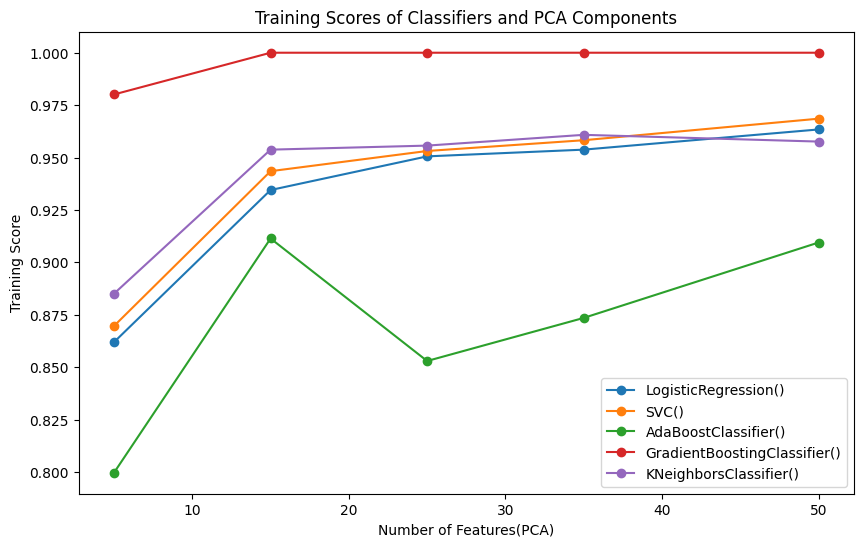

In [426]:
results,components,_=model_selection(X_train_shuffled, y_train_shuffled)
# Plot the results
plt.figure(figsize=(10, 6))
for classifier, scores in results.items():
    plt.plot(components, scores, marker='o', label=classifier)
# add plot labels
plt.xlabel('Number of Features(PCA)')                             
plt.ylabel('Training Score')
plt.title('Training Scores of Classifiers and PCA Components')
#show legend
plt.legend()
plt.show();

#### MODELLING WITH N-GRAMS BAG OF WORDS FEATURES

In [427]:
X_train,X_test, y_train, y_test=train_test_split(X_NG,y, test_size=0.3)

# Shuffle the training data and labels
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train) #splits data into 70% training and 30%testing

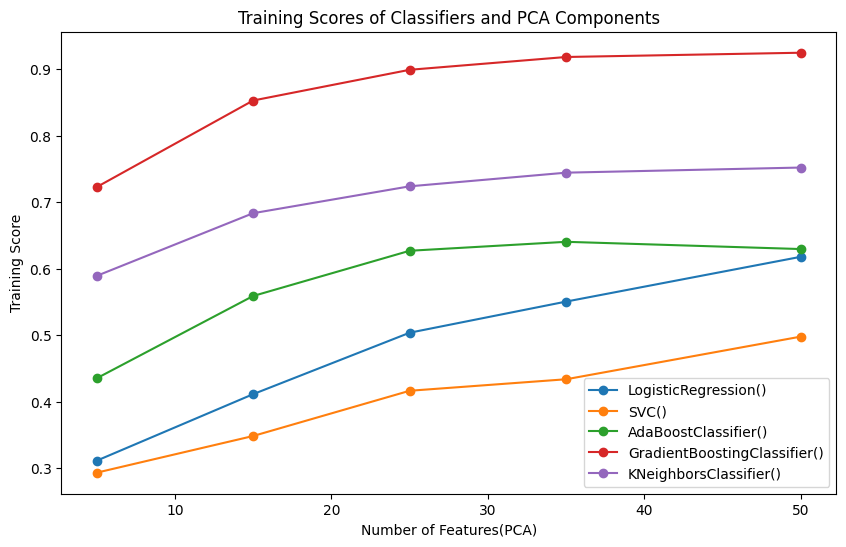

In [428]:
results,components,_=model_selection(X_train_shuffled, y_train_shuffled)
# Plot the results
plt.figure(figsize=(10, 6))
for classifier, scores in results.items():
    plt.plot(components, scores, marker='o', label=classifier)
# add plot labels
plt.xlabel('Number of Features(PCA)')                             
plt.ylabel('Training Score')
plt.title('Training Scores of Classifiers and PCA Components')
#show legend
plt.legend()
plt.show();

#### MODELLING WITH TF-IDF FEATURES

In [429]:
X_train,X_test, y_train, y_test=train_test_split(X_TFIDF,y, test_size=0.3)

# Shuffle the training data and labels
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train) #splits data into 70% training and 30%testing

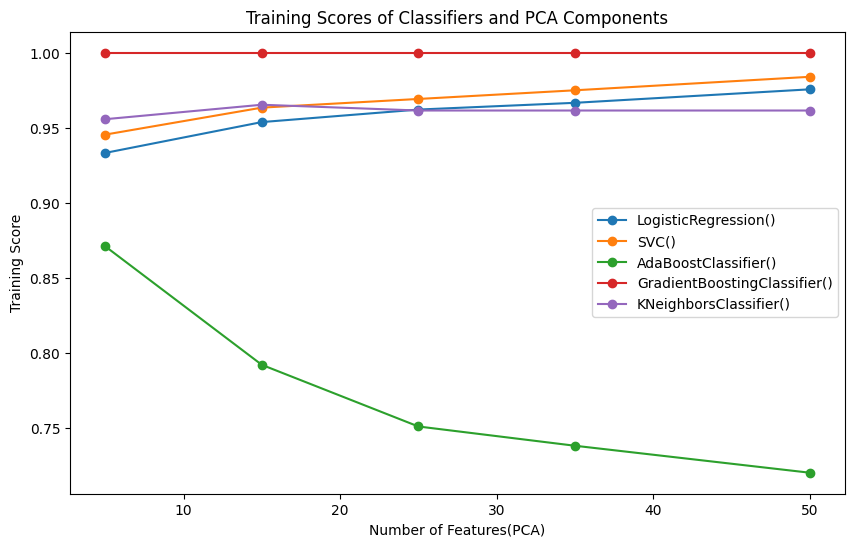

In [430]:
results,components,_=model_selection(X_train_shuffled, y_train_shuffled)
# Plot the results
plt.figure(figsize=(10, 6))
for classifier, scores in results.items():
    plt.plot(components, scores, marker='o', label=classifier)
# add plot labels
plt.xlabel('Number of Features(PCA)')                             
plt.ylabel('Training Score')
plt.title('Training Scores of Classifiers and PCA Components')
#show legend
plt.legend()
plt.show();

### Parameter Tuning with TF-IDF Features and Support Vector Machine

In [431]:
X_train,X_test, y_train, y_test=train_test_split(X_TFIDF,y, test_size=0.3)

# Shuffle the training data and labels
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train) #splits data into 70% training and 30%testing

In [432]:

#pipeline steps
steps=[                   
    ('scaler',MinMaxScaler()),
    ('pca', PCA(n_components=15)),
    ('classifier', SVC())
]




# parameters grid for GridSearchCV
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],  # Regularization parameter
    'classifier__gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'classifier__kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Kernel type
}

# Create GridSearchCV object
grid_search = GridSearchCV(Pipeline(steps), param_grid, cv=5)

# Fit the grid search to your data
grid_search.fit(X_train_shuffled, y_train_shuffled)  # Replace X_train and y_train with your training data

# Get the best parameters
best_params = grid_search.best_params_

# Get the best estimator
best_estimator = grid_search.best_estimator_

In [433]:
best_estimator

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=15)),
                ('classifier', SVC(C=1, gamma=0.001, kernel='linear'))])

In [434]:
grid_search.best_score_

0.9428415368125979

In [435]:
best_params

{'classifier__C': 1,
 'classifier__gamma': 0.001,
 'classifier__kernel': 'linear'}

### MODEL EVALUATION

#### ON TRAINING

In [454]:
model=best_estimator   # Get best model

In [455]:
model.score(X_train,y_train)   # evaluate on training set

0.9511881824020553

In [438]:
y_train_pred=model.predict(X_train)  # get predictions on training set

In [439]:
#get confusion matrix for plotting with training set
confusion_matrix = metrics.confusion_matrix(y_train, y_train_pred)   
ConfusionMatrixDisplay=metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels = labels)

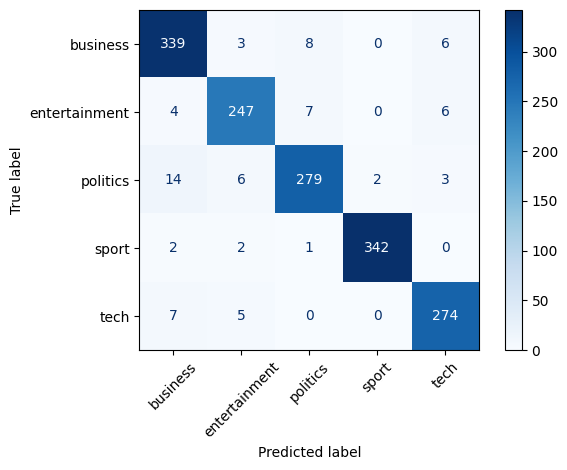

In [441]:
ConfusionMatrixDisplay.plot(cmap='Blues')

# Adjustments if necessary
plt.xticks(rotation=45)  # Rotate labels if necessary
plt.tight_layout()

# Show the plot
plt.show()

#### ON TESTING

In [442]:
print("Model's Performance on Test set =", model.score(X_test,y_test))

Model's Performance on Test set = 0.9670658682634731


In [443]:
y_test_pred=model.predict(X_test) #get test predictions

In [446]:
#get confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)  
ConfusionMatrixDisplay=metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels = labels)

In [483]:
confusion_matrix

array([[151,   1,   2,   0,   0],
       [  1, 116,   3,   0,   2],
       [  1,   0, 108,   2,   2],
       [  0,   0,   0, 164,   0],
       [  2,   5,   1,   0, 107]], dtype=int64)

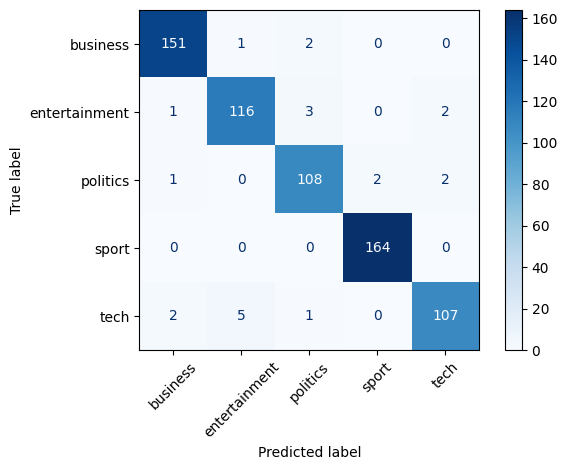

In [447]:
ConfusionMatrixDisplay.plot(cmap='Blues')

# Adjustments if necessary
plt.xticks(rotation=45)  # Rotate labels if necessary
plt.tight_layout()

# Show the plot
plt.show()

### NEURAL NETWORKS APPROACH

In [369]:
# Reset all state generated by Keras.
tf.keras.backend.clear_session()

In [370]:
X=df["Normalized_Content"].values
y=df["Category_Factor"].values
X_train,X_test, y_train, y_test=train_test_split(X,y, test_size=0.3, random_state=42)

In [371]:
y_train[:5]

array([3, 3, 3, 2, 1], dtype=int64)

In [372]:
# set up cnn parameters
maxlen = 100 #max length of each sequence
emb_dim = 100 #embedding dimension
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)
vocab = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [377]:
# Initialize SMOTE for dealing imbalance data
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE 
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert y_train back to one-hot encoding
y_train_resampled = to_categorical(y_train_resampled, num_classes=5)

# Check the new class distribution
print("Class distribution after oversampling:", Counter(y_train_resampled.argmax(axis=1)))

Class distribution after oversampling: Counter({3: 371, 2: 371, 1: 371, 0: 371, 4: 371})


In [385]:
X_train= X_train_resampled
y_train= y_train_resampled

In [386]:
row, cols= X_train.shape

In [387]:
model= Sequential()
model.add(Embedding(input_dim=vocab, output_dim=emb_dim, input_length=cols)) #input layer
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPool1D(3))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [388]:
print(X_train.shape)
print(y_train.shape)

(1855, 100)
(1855, 5)


In [382]:
X_train=np.array(X_train)
y_train=np.array(y_train)

In [389]:


# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("nnmodel.keras",monitor="loss",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, 
                              min_delta=0.0001, verbose=1)

In [390]:
# # Convert target to one-hot encoding
# y_train = to_categorical(y_train, num_classes=5)
# y_test = to_categorical(y_test, num_classes=5)


model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2111 - loss: 1.6098
Epoch 1: loss improved from inf to 1.60613, saving model to nnmodel.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.2112 - loss: 1.6097 - learning_rate: 0.0010
Epoch 2/20
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3968 - loss: 1.5121
Epoch 2: loss improved from 1.60613 to 1.46724, saving model to nnmodel.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3970 - loss: 1.5106 - learning_rate: 0.0010
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6249 - loss: 1.0449
Epoch 3: loss improved from 1.46724 to 0.93631, saving model to nnmodel.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6252 - loss: 1.0431 - learning_rate: 0.0010
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7935 - loss: 0.5641
Epoch 4: loss improved from 0.93631 to 0.52951, saving model to nnmodel.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.7935

In [391]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       2,322,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 96, 32)              │          16,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 32, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │          20,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,078,313 (27.00 MB)

 Trainable params: 2,359,437 (9.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,718,876 (18.00 MB)

In [392]:
# Load the model from the file
model = load_model("nnmodel.keras")

In [394]:
model.evaluate(X_test,y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9479 - loss: 0.2443


[0.28918737173080444, 0.9356287717819214]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'business'),
  Text(1, 0, 'entertainment'),
  Text(2, 0, 'politics'),
  Text(3, 0, 'sport'),
  Text(4, 0, 'tech')])

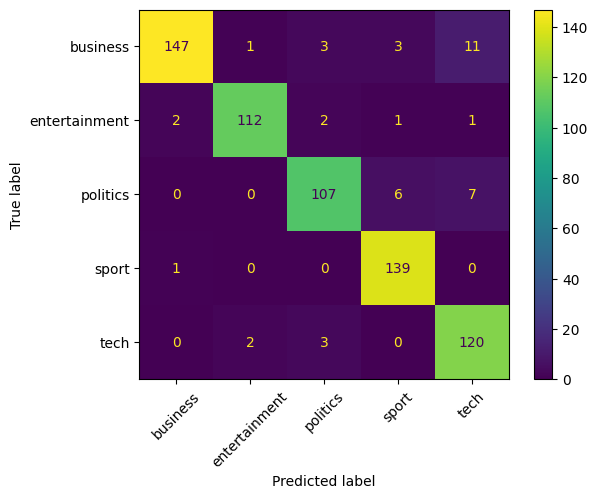

In [405]:
# Convert one-hot encoded y_test to class labels
y_test_labels = y_test.argmax(axis=1)  # Convert true labels to class format

# Get predictions and convert probabilities to class labels
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.argmax(axis=1)

# Compute and display the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test_labels, y_test_pred)
ConfusionMatrixDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
ConfusionMatrixDisplay.plot()

# Rotate x-axis labels by 45 degrees 
plt.xticks(rotation=45)

In [457]:
import joblib

joblib.dump(model, 'best_model.pkl')

['best_model.pkl']

In [450]:
# Or, alternatively, sample a fraction of the data
sample_data = df.sample(frac=0.1, random_state=42)  # Sample 10% of the data

In [458]:
# Save the DataFrame to a CSV file
sample_data.to_csv('sample_articles.csv', index=False)

In [476]:
article= sample_data['Content'][1644]

In [477]:
from preprocess import normalize_document

with open('best_model.pkl', 'rb') as m:
    model = joblib.load(m)

with open('tfidf_vectorizer.pkl', 'rb') as v:
    tv = pickle.load(v)

norm_art = normalize_document(article)

In [478]:
# Transform the normalized article using the TF-IDF Vectorizer
X_test_tfidf = tv.transform([norm_art])

# Convert the sparse matrix to a dense numpy array
X_test_dense = X_test_tfidf.toarray()

# Predict the category using the loaded model
prediction = model.predict(X_test_dense)

# Map the index to the category name
predicted_category = labels[[prediction[0]]]  # Get the category name

# Display the result
print(f"The predicted category is: {predicted_category}")

# Display the predicted category
print(f"Predicted Category: {prediction[0]}")

The predicted category is: Index(['sport'], dtype='object')
Predicted Category: 3


In [473]:
sample_data.head()

,Category,Content
414,business,UK house prices dip in November\n\nUK house pr...
420,business,LSE 'sets date for takeover deal'\n\nThe Londo...
1644,sport,Harinordoquy suffers France axe\n\nNumber eigh...
416,business,Barclays shares up on merger talk\n\nShares in...
1232,politics,Campaign 'cold calls' questioned\n\nLabour and...
